In [1]:
import pandas as pd
from itertools import chain, tee, combinations
from functools import reduce, wraps
from operator import mul
from collections import defaultdict, Counter
import random
import time
import numpy as np
import copy
import json
import os
import sys

import arrow

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Exploratory Data Analysis
Here, I manually re-formatted the raw dataset into a form which contains journeys. Due to Naming Simplifications while training the models, I used the following pseudo variables to substitute the NBA leads: 

Alpha --> Service Standard/BDM Service Standard

Beta --> Rdemption Risk

Delta --> Trending Low in RRSP/Spring/Fall/Summer GS

Epsilon --> RRSP/SPRING/SUMMER/FALL GS

Eta --> Fund Reco

Gamma --> Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads Webcast Reco

Iota --> Webcast Reco

Kappa --> Webcast Follow Up Short-Term +ve GS Momentum

Lambda --> Short-Term +ve GS Momentum 

Mi --> Short-Term -ve GS Momentum

Theta --> High Fund/PM Concentration

Zeta --> Rec List

In [2]:
GP = pd.read_csv("Datasets/final_dataset_12_reasons_before_reformat.csv")

In [3]:
GP

,IP,date,Service Standard / BDM Service Standard,Redemption Risk,Trending Low in RRSP/SPRING/SUMMER/FALL GS,RRSP/SPRING/SUMMER/FALL Prospect,Fund Reco,Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads,Webcast Reco,Webcast Follow Up / First Webcast Follow Up,Short Term +ve GS Momentum,Short Term -ve GS Momentum,High Fund/PM Concentration,Rec List,conversions,conversion_value
0,108327,3/27/2021,0,0,0,0,0,0,0,0,0,1,0,0,0,0.00
1,108388,5/14/2021,1,0,0,0,0,0,0,0,0,0,0,0,0,0.00
2,108471,6/3/2021,0,0,0,1,1,1,0,0,0,0,0,0,1,18250.23
3,108471,9/10/2021,0,0,0,1,1,0,0,0,0,0,0,0,1,23832.50
4,108471,9/25/2021,0,0,0,1,1,0,0,0,0,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40116,2306893,10/15/2021,0,0,0,0,0,0,0,1,0,0,0,0,0,0.00
40117,2306904,10/15/2021,0,0,0,0,0,0,0,1,0,0,0,0,0,0.00
40118,2306905,10/15/2021,0,0,0,0,0,0,1,0,0,0,0,0,0,0.00
40119,1100010007,2/25/2021,0,0,0,0,0,0,1,0,0,1,0,0,0,0.00


In [4]:
dic_freq = {"alpha": 0, "beta": 0, "delta": 0, "epsilon":0, "eta":0, "gamma": 0, "iota": 0, "kappa": 0, "lambda": 0, "mi": 0, "theta": 0, "zeta": 0}

In [6]:
journey = pd.read_csv("Datasets/journey.csv")

#journey.loc[1]["path"].split(" > ")

In [7]:
for i in range(len(journey["path"])):
    each_list = journey["path"][i].split(" > ")
    for each in each_list:
        dic_freq[each] += 1

In [8]:
dic_freq

{'alpha': 354394,
 'beta': 2767817,
 'delta': 1017735,
 'epsilon': 2547670,
 'eta': 1945206,
 'gamma': 2955088,
 'iota': 2060057,
 'kappa': 985564,
 'lambda': 630051,
 'mi': 1488306,
 'theta': 1168153,
 'zeta': 45477}

In [9]:
result = {"Service Standard": 0, "Redemption Risk": 0, "Trending Low in Seasons GS": 0, "Seasons Prospect":0, "Fund Reco":0, "Web Leads": 0, "Webcast Reco": 0, "Webcast Follow Up": 0, "Short Term +ve GS Momentum": 0, "Short Term -ve GS Momentum": 0, "High Fund": 0, "Rec List": 0}

In [10]:
result["Service Standard"] = dic_freq["alpha"]
result["Redemption Risk"] = dic_freq["beta"]
result["Trending Low in Seasons GS"] = dic_freq["delta"]
result["Seasons Prospect"] = dic_freq["epsilon"]
result["Fund Reco"] = dic_freq["eta"]
result["Web Leads"] = dic_freq["gamma"]
result["Webcast Reco"] = dic_freq["iota"]
result["Webcast Follow Up"] = dic_freq["kappa"]
result["Short Term +ve GS Momentum"] = dic_freq["lambda"]
result["Short Term -ve GS Momentum"] = dic_freq["mi"]
result["High Fund"] = dic_freq["theta"]
result["Rec List"] = dic_freq["zeta"]

In [11]:
result

{'Service Standard': 354394,
 'Redemption Risk': 2767817,
 'Trending Low in Seasons GS': 1017735,
 'Seasons Prospect': 2547670,
 'Fund Reco': 1945206,
 'Web Leads': 2955088,
 'Webcast Reco': 2060057,
 'Webcast Follow Up': 985564,
 'Short Term +ve GS Momentum': 630051,
 'Short Term -ve GS Momentum': 1488306,
 'High Fund': 1168153,
 'Rec List': 45477}

In [12]:
tot_sum = sum(result.values())

In [13]:
tot_sum

17965518

In [14]:
result_list = list(result)
result_list

['Service Standard',
 'Redemption Risk',
 'Trending Low in Seasons GS',
 'Seasons Prospect',
 'Fund Reco',
 'Web Leads',
 'Webcast Reco',
 'Webcast Follow Up',
 'Short Term +ve GS Momentum',
 'Short Term -ve GS Momentum',
 'High Fund',
 'Rec List']

### Model Implementation (All 10 models are implemented in the following NBA Class)

In [17]:
def show_time(func):
    """timer decorator"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time.time()
        print(f'running {func.__name__}.. ', end='')
        sys.stdout.flush()
        v = func(*args, **kwargs)
        m, s = divmod(time.time() - t0, 60)
        st = 'elapsed time:'
        if m:
            st += ' ' + f'{m:.0f} min'
        if s:
            st += ' ' + f'{s:.3f} sec'
        print(st)
        return v
    return wrapper

class NBA:
    def __init__(self, data='Datasets/journey.csv', allow_loops=False, add_timepoints=True, sep=' > '):
        self.data = pd.read_csv(data)
        self.sep = sep
        self.NULL = '(null)'
        self.START = '(start)'
        self.CONV = '(conversion)'
        if not (set(self.data.columns) <= set('path total_conversions total_conversion_value total_null exposure_times'.split())):
            raise ValueError(f'wrong column names in {data}!')
        if add_timepoints:
            self.add_exposure_times(1)
        if not allow_loops:
            self.remove_loops()
        # we'll work with lists in path and exposure_times from now on
        self.data[['path', 'exposure_times']] = self.data[['path', 'exposure_times']].applymap(lambda _: [ch.strip() for ch in _.split(self.sep.strip())])
        # make a sorted list of channel names
        self.channels = sorted(list({ch for ch in chain.from_iterable(self.data['path'])}))
        # add some extra channels
        self.channels_ext = [self.START] + self.channels + [self.CONV, self.NULL]
        # make dictionary mapping a channel name to it's index
        self.c2i = {c: i for i, c in enumerate(self.channels_ext)}
        # and reverse
        self.i2c = {i: c for c, i in self.c2i.items()}
        self.removal_effects = defaultdict(float)
        # touch points by channel
        self.tps_by_channel = {'c1': ['beta', 'iota', 'gamma'],'c2': ['alpha', 'delta', 'kappa', 'mi'],'c3': ['epsilon', 'lambda', 'eta', 'theta', "zeta"]}
        self.attribution = defaultdict(lambda: defaultdict(float))

    def __repr__(self):
        return f'{self.__class__.__name__} with {len(self.channels)} channels: {", ".join(self.channels)}'

    def add_exposure_times(self, dt=None):
        """
        generate synthetic exposure times; if dt is specified, the exposures will be dt=1 sec away from one another, otherwise
        we'll generate time spans randomly - the times are of the form 2018-11-26T03:54:26.532091+00:00
        """
        if 'exposure_times' in self.data.columns:
            return self
        ts = []    # this will be a list of time instant lists one per path 
        if dt:
            _t0 = arrow.utcnow()
            self.data['path'].str.split('>') \
                .apply(lambda _: [ch.strip() for ch in _]) \
                .apply(lambda lst: ts.append(self.sep.join([r.format('YYYY-MM-DD HH:mm:ss') 
                                    for r in arrow.Arrow.range('second', _t0, _t0.shift(seconds=+(len(lst) - 1)))])))
        self.data['exposure_times'] = ts
        return self

    @show_time
    def remove_loops(self):
        """
        remove transitions from a channel directly to itself, e.g. a > a
        """
        cpath = []
        cexposure = []
        self.data[['path', 'exposure_times']] = self.data[['path', 'exposure_times']].applymap(lambda _: [ch.strip() for ch in _.split('>')]) 
        for row in self.data.itertuples():
            clean_path = []
            clean_exposure_times = []
            for i, p in enumerate(row.path, 1):
                if i == 1:
                    clean_path.append(p)
                    clean_exposure_times.append(row.exposure_times[i-1])
                else:
                    if p != clean_path[-1]:
                        clean_path.append(p)
                        clean_exposure_times.append(row.exposure_times[i-1])
            cpath.append(self.sep.join(clean_path))
            cexposure.append(self.sep.join(clean_exposure_times))
        self.data_ = pd.concat([pd.DataFrame({'path': cpath}), 
                                self.data[[c for c in self.data.columns if c not in 'path exposure_times'.split()]],
                                pd.DataFrame({'exposure_times': cexposure})], axis=1)
        _ = self.data_[[c for c in self.data.columns if c != 'exposure_times']].groupby('path').sum().reset_index()
        self.data = _.join(self.data_[['path', 'exposure_times']].set_index('path'), on='path', how='inner').drop_duplicates(['path'])
        return self

    def normalize_dict(self, d):
        """
        returns a value-normalized version of dictionary d using frequency, counts for each lead reasons in their respective paths
        """
        count = 0
        for _ in d:
            d[_] *= tot_sum
            d[_] /= result[result_list[count]]
            count += 1
        sum_all_values = sum(d.values())
        for _ in d:
            d[_] = round(d[_]/sum_all_values, 3)
        return d

    @show_time
    def linear(self, share='same', normalize=True):
        """
        either give exactly the same share of conversions to each visited channel (option share=same) or
        distribute the shares proportionally, i.e. if a channel 1 appears 2 times on the path and channel 2 once
        then channel 1 will receive double credit
        note: to obtain the same result as ChannelAttbribution produces for the test data set, you need to
        - select share=proportional
        - allow loops - use the data set as is without any modifications
        """
        if share not in 'same proportional'.split():
            raise ValueError('share parameter must be either *same* or *proportional*!')
        self.linear = defaultdict(float)
        for row in self.data.itertuples():
            if row.total_conversions:
                if share == 'same':
                    n = len(set(row.path))    # number of unique channels visited during the journey
                    s = row.total_conversions/n    # each channel is getting an equal share of conversions
                    for c in set(row.path):
                        self.linear[c] += s
                elif share == 'proportional':
                    c_counts = Counter(row.path)  # count how many times channels appear on this path
                    tot_appearances = sum(c_counts.values())
                    c_shares = defaultdict(float)
                    for c in c_counts:
                        c_shares[c] = c_counts[c]/tot_appearances
                    for c in set(row.path):
                        self.linear[c] += row.total_conversions*c_shares[c]
        if normalize:
            self.linear = self.normalize_dict(self.linear)
        self.attribution['linear'] = self.linear
        return self

    @show_time
    def position_based(self, r=(40,40), normalize=True):
        """give 40% credit to the first and last channels and divide the rest equally across the remaining channels"""
        self.position_based = defaultdict(float)
        for row in self.data.itertuples():
            if row.total_conversions:
                n = len(set(row.path))
                if n == 1:
                    self.position_based[row.path[-1]] += row.total_conversions
                elif n == 2:
                    equal_share  = row.total_conversions/n
                    self.position_based[row.path[0]] += equal_share
                    self.position_based[row.path[-1]] += equal_share
                else:
                    self.position_based[row.path[0]] += r[0]*row.total_conversions/100
                    self.position_based[row.path[-1]] += r[1]*row.total_conversions/100
                    for c in row.path[1:-1]:
                        self.position_based[c] += (100 - sum(r))*row.total_conversions/(n - 2)/100
        if normalize:
            self.position_based = self.normalize_dict(self.position_based)
        self.attribution['pos_based'] = self.position_based
        return self

    @show_time
    def time_decay(self, count_direction='left', normalize=True):
        """
        time decay - the closer to conversion was exposure to a channel, the more credit this channel gets
        this can work differently depending how you get timing sorted. 
        example: a > b > c > b > a > c > (conversion)
        we can count timing backwards: c the latest, then a, then b (lowest credit) and done. Or we could count left to right, i.e.
        a first (lowest credit), then b, then c. 
        """
        self.time_decay = defaultdict(float)
        if count_direction not in 'left right'.split():
            raise ValueError('argument count_direction must be *left* or *right*!')
        for row in self.data.itertuples():
            if row.total_conversions:
                channels_by_exp_time = []
                _ = row.path if count_direction == 'left' else row.path[::-1]
                for c in _:
                    if c not in channels_by_exp_time:
                        channels_by_exp_time.append(c)
                if count_direction == 'right':
                    channels_by_exp_time = channels_by_exp_time[::-1]
                # first channel gets 1, second 2, etc.
                score_unit = 1./sum(range(1, len(channels_by_exp_time) + 1))
                for i, c in enumerate(channels_by_exp_time, 1):
                    self.time_decay[c] += i*score_unit*row.total_conversions
        if normalize:
            self.time_decay = self.normalize_dict(self.time_decay)
        self.attribution['time_decay'] = self.time_decay
        return self
    
    @show_time
    def first_touch(self, normalize=True):
        first_touch = defaultdict(int)
        for c in self.channels:
            # total conversions for all paths where the first channel was c
            first_touch[c] = self.data.loc[self.data['path'].apply(lambda _: _[0] == c), 'total_conversions'].sum()
        if normalize:
            first_touch = self.normalize_dict(first_touch)
        self.attribution['first_touch'] = first_touch
        return self

    @show_time
    def last_touch(self, normalize=True):
        last_touch = defaultdict(int)
        for c in self.channels:
            # total conversions for all paths where the last channel was c
            last_touch[c] = self.data.loc[self.data['path'].apply(lambda _: _[-1] == c), 'total_conversions'].sum()
        if normalize:
            last_touch = self.normalize_dict(last_touch)
        self.attribution['last_touch'] = last_touch
        return self

    def pairs(self, lst):
        it1, it2 = tee(lst)
        next(it2, None)
        return zip(it1, it2)

    def count_pairs(self):
        """count how many times channel pairs appear on all recorded customer journey paths"""
        c = defaultdict(int)
        for row in self.data.itertuples():
            for ch_pair in self.pairs([self.START] + row.path):
                c[ch_pair] += (row.total_conversions + row.total_null)
            c[(row.path[-1], self.NULL)] += row.total_null
            c[(row.path[-1], self.CONV)] += row.total_conversions
        return c

    def ordered_tuple(self, t):
        """return tuple t ordered """
        sort = lambda t: tuple(sorted(list(t)))
        return (t[0],) + sort(t[1:]) if (t[0] == self.START) and (len(t) > 1) else sort(t)

    def trans_matrix(self):
        """
        calculate transition matrix which will actually be a dictionary mapping 
        a pair (a, b) to the probability of moving from a to b, e.g. T[(a, b)] = 0.5
        """
        tr = defaultdict(float)
        outs = defaultdict(int)
        # here pairs are unordered
        pair_counts = self.count_pairs()
        for pair in pair_counts:
            outs[pair[0]] += pair_counts[pair]
        for pair in pair_counts:
            tr[pair] = pair_counts[pair]/outs[pair[0]]
        return tr

    @show_time
    def simulate_path(self, trans_mat, drop_channel=None, n=int(1e6)):
        """
        generate n random user journeys and see where these users end up - converted or not;
        drop_channel is a channel to exclude from journeys if specified
        """
        outcome_counts = defaultdict(int)
        idx0 = self.c2i[self.START]
        null_idx = self.c2i[self.NULL]
        conv_idx = self.c2i[self.CONV]
        drop_idx = self.c2i[drop_channel] if drop_channel else null_idx
        for _ in range(n):
            stop_flag = None
            while not stop_flag:
                probs = [trans_mat.get((self.i2c[idx0], self.i2c[i]), 0) for i in range(len(self.channels_ext))]
                # index of the channel where user goes next
                idx1 = np.random.choice([self.c2i[c] for c in self.channels_ext], p=probs, replace=False)
                if idx1 == conv_idx:
                    outcome_counts[self.CONV] += 1
                    stop_flag = True
                elif idx1 in {null_idx, drop_idx}:
                    outcome_counts[self.NULL] += 1
                    stop_flag = True
                else:
                    idx0 = idx1
        return outcome_counts

    def prob_convert(self, trans_mat, drop=None):
        _d = self.data[self.data['path'].apply(lambda x: drop not in x) & (self.data['total_conversions'] > 0)]
        p = 0
        for row in _d.itertuples():
            pr_this_path = []
            for t in self.pairs([self.START] + row.path + [self.CONV]):
                pr_this_path.append(trans_mat.get(t, 0))
            p += reduce(mul, pr_this_path)
        return p

    @show_time
    def markov(self, sim=False, normalize=True):
        markov = defaultdict(float)
        # calculate the transition matrix
        tr = self.trans_matrix()
        if not sim:
            p_conv = self.prob_convert(trans_mat=tr)
            for c in self.channels:
                markov[c] = (p_conv - self.prob_convert(trans_mat=tr, drop=c))/p_conv
        else:
            outcomes = defaultdict(lambda: defaultdict(float))
            # get conversion counts when all chennels are in place
            outcomes['full'] = self.simulate_path(trans_mat=tr, drop_channel=None)
            for c in self.channels:
                outcomes[c] = self.simulate_path(trans_mat=tr, drop_channel=c)
                # removal effect for channel c
                markov[c] = (outcomes['full'][self.CONV] - outcomes[c][self.CONV])/outcomes['full'][self.CONV]
        if normalize:
            markov = self.normalize_dict(markov)
        self.attribution['markov'] = markov
        return self

    @show_time
    def shao(self, normalize=True):
        """
        probabilistic model by Shao and Li (supposed to be equivalent to Shapley); explanation in the original paper may seem rather unclear but
        this https://stats.stackexchange.com/questions/255312/multi-channel-attribution-modelling-using-a-simple-probabilistic-model 
        is definitely helpful
        """
        r = defaultdict(lambda: defaultdict(float))
        # count user conversions and nulls for each visited channel and channel pair
        for row in self.data.itertuples():
            for n in range(1, 3):
                # # combinations('ABCD', 2) --> AB AC AD BC BD CD
                for ch in combinations(set(row.path), n):
                    t = self.ordered_tuple(ch)
                    r[t][self.CONV] += row.total_conversions
                    r[t][self.NULL] += row.total_null
        for _ in r:
            r[_]['conv_prob'] = r[_][self.CONV]/(r[_][self.CONV] + r[_][self.NULL])
        # calculate channel contributions
        self.C = defaultdict(float)
        for row in self.data.itertuples():
            for ch_i in set(row.path):
                if row.total_conversions:
                    pc = 0    # contribution for current path
                    other_channels = set(row.path) - {ch_i}
                    k = 2*len(other_channels) if other_channels else 1 
                    for ch_j in other_channels:
                        pc += (r[self.ordered_tuple((ch_i, ch_j))]['conv_prob'] - r[(ch_i,)]['conv_prob'] - r[(ch_j,)]['conv_prob'])
                    pc = r[(ch_i,)]['conv_prob']  + pc/k
                    self.C[ch_i] += row.total_conversions*pc
        if normalize:
            self.C = self.normalize_dict(self.C)
        self.attribution['shao'] = self.C
        return self

    def get_generated_conversions(self, max_subset_size=12):
        self.cc = defaultdict(lambda: defaultdict(float))
        for ch_list, convs, nulls in zip(self.data['path'],self.data['total_conversions'],self.data['total_null']):
            # only look at journeys with conversions
            for n in range(1, max_subset_size + 1):
                for tup in combinations(set(ch_list), n):
                    tup_ = self.ordered_tuple(tup)
                    self.cc[tup_][self.CONV] += convs
                    self.cc[tup_][self.NULL] += nulls
        return self

    def v(self, coalition):
        """
        total number of conversions generated by all subsets of the coalition;
        coalition is a tuple of channels
        """
        s = len(coalition)
        total_convs = 0
        for n in range(1, s+1):
            for tup in combinations(coalition, n):
                tup_ = self.ordered_tuple(tup)
                total_convs += self.cc[tup_][self.CONV]
        return total_convs

    def w(self, s, n):
        return np.math.factorial(s)*(np.math.factorial(n - s -1))/np.math.factorial(n)

    @show_time
    def shapley(self, max_coalition_size=12, normalize=True):
        """
        Shapley model; channels are players, the characteristic function maps a coalition A to the 
        the total number of conversions generated by all the subsets of the coalition
        see https://medium.com/data-from-the-trenches/marketing-attribution-e7fa7ae9e919
        """
        self.get_generated_conversions(max_subset_size=12)
        self.phi = defaultdict(float)
        for ch in self.channels:
            # all subsets of channels that do NOT include ch
            for n in range(1, max_coalition_size + 1):
                for tup in combinations(set(self.channels) - {ch}, n):
                    self.phi[ch] += (self.v(tup + (ch,)) - self.v(tup))*self.w(len(tup), len(self.channels))
        if normalize:
            self.phi = self.normalize_dict(self.phi)
        self.attribution['shapley'] = self.phi
        return self

    @show_time
    def logistic_regression(self, test_size=0.25, ps=0.5, pc=0.5, normalize=True, n=2000):
        """
        test_size is the proportion of data set to use as the test set
        ps is the proportion of rows to sample
        pc is the proportion of columns to sample
        n is the number of iterations
        """
        lr = defaultdict(float)
        # expand the original data set into a feature matrix
        lists_ = []
        flags_ = []
        for i, row in enumerate(self.data.itertuples()):
            for _ in range(row.total_conversions):
                lists_.append({c: 1 for c in row.path})
                flags_.append(1)
            for _ in range(row.total_null):
                lists_.append({c: 1 for c in row.path})
                flags_.append(0)
        data_ = pd.concat([pd.DataFrame(lists_).fillna(0),pd.DataFrame({'conv': flags_})], axis=1).sample(frac=1.0)
        for _ in range(1, n + 1):
            dd = pd.concat([data_[data_['conv'] == 1].sample(frac=0.5),data_[data_['conv'] == 0].sample(frac=0.5)])
            # randomly sample features (channels) and rows (journeys)
            dd = dd.sample(frac=ps)
            dd = pd.concat([dd.drop('conv', axis=1).sample(frac=pc, axis=1), dd['conv']], axis=1)
            # split into training/test set
            X_train, X_test, y_train, y_test = train_test_split(dd.drop('conv', axis=1), dd['conv'],test_size=test_size, random_state=36, stratify=dd['conv'])
            # fit logistic regression classifier
            clf = LogisticRegression(random_state=32, solver='lbfgs', fit_intercept=False).fit(X_train, y_train)
            # predict conversion labels for the test set
            yh = clf.predict(X_test)
            minc = min(clf.coef_[0])
            maxc = max(clf.coef_[0])
            for c, coef in zip(X_train.columns, [k*k for k in clf.coef_[0]]):
                lr[c] += coef/n
        if normalize:
            lr = self.normalize_dict(lr)
        self.attribution['linreg'] = lr
        return self

    def show(self):
        """show simulation results"""
        res = pd.DataFrame.from_dict(self.attribution)
        return res

    def rois(self, attrib, spend, cv):
        """
        calculate ROIs as suggested in paper
        Geyik et al (2014) - Multi-Touch Attribution Based Budget Allocation in Online Advertising
        attrib is a dictionary of attributions per touch point
        spend is a dictionary of spent dollars per channel 
        cv is the conversion value (in dollars)
        """
        roi = defaultdict(float)
        for c in self.tps_by_channel:
            roi[c] = sum([attrib[tp] for tp in self.tps_by_channel[c]])*cv/spend[c]
        return roi

    def pi(self, path, exposure_times, conv_flag, beta_by_channel, omega_by_channel):
        """
        calculate contribution of channel i to conversion of journey (user) u - (p_i^u) in the paper
         - path is a list of states that includes (start) but EXCLUDES (null) or (conversion)
         - exposure_times is list of exposure times
        """
        p = {c: 0 for c in path}    # contributions by channel
        # all contributions are zero if no conversion
        if not conv_flag:
            return p
        dts = [(arrow.get(exposure_times[-1]) - arrow.get(t)).seconds for t in exposure_times]
        _ = defaultdict(float)
        for c, dt in zip(path, dts):
            _[c] += beta_by_channel[c]*omega_by_channel[c]*np.exp(-omega_by_channel[c]*dt)
        for c in _:
            p[c] = _[c]/sum(_.values())
        return p

    def update_coefs(self, beta, omega):
        """return updated beta and omega"""
        delta = 1e-3
        beta_num = defaultdict(float)
        beta_den = defaultdict(float)
        omega_den = defaultdict(float)
        for u, row in enumerate(self.data.itertuples()):
            p = self.pi(row.path, row.exposure_times, row.total_conversions, beta, omega)
            r = copy.deepcopy(row.path)
            dts = [(arrow.get(row.exposure_times[-1]) - arrow.get(t)).seconds for t in row.exposure_times]
            while r:
                # pick channels starting from the last one
                c = r.pop()
                dt = dts.pop()
                beta_den[c] += (1.0 - np.exp(-omega[c]*dt))
                omega_den[c] += (p[c]*dt + beta[c]*dt*np.exp(-omega[c]*dt))
                beta_num[c] += p[c]
        # now that we gone through every user, update coefficients for every channel
        beta0 = copy.deepcopy(beta)
        omega0 = copy.deepcopy(omega)
        df = []
        for c in self.channels:
            beta_num[c] = (beta_num[c] > 1e-6)*beta_num[c]
            beta_den[c] = (beta_den[c] > 1e-6)*beta_den[c]
            omega_den[c] = max(omega_den[c], 1e-6)
            if beta_den[c]:
                beta[c] = beta_num[c]/beta_den[c]
            omega[c] = beta_num[c]/omega_den[c]
            df.append(abs(beta[c] - beta0[c]) < delta)
            df.append(abs(omega[c] - omega0[c]) < delta)
        return (beta, omega, sum(df))
    
    @show_time
    def additive_hazard(self, epochs=20, normalize=True):
        """additive hazard model as in Multi-Touch Attribution in On-line Advertising with Survival Theory"""
        beta = {c: random.uniform(0.001,1) for c in self.channels}
        omega = {c: random.uniform(0.001,1) for c in self.channels}
        for _ in range(epochs):
            beta, omega, h = self.update_coefs(beta, omega)
            if h == 2*len(self.channels):
                print(f'converged after {_ + 1} iterations')
                break
        # time window: take the max time instant across all journeys that converged
        additive_hazard = defaultdict(float)
        for u, row in enumerate(self.data.itertuples()):
            p = self.pi(row.path, row.exposure_times, row.total_conversions, beta, omega)
            for c in p:
                additive_hazard[c] += p[c]
        if normalize:
            additive_hazard = self.normalize_dict(additive_hazard)
        self.attribution['add_haz'] = additive_hazard
        return self

In [ ]:
if __name__ == '__main__':
    nba = NBA(data='Datasets/journey.csv', allow_loops=True)
    final_result = (nba.first_touch().last_touch().linear(share='proportional').position_based().time_decay(count_direction='right').shapley().shao().markov(sim=False).logistic_regression().additive_hazard().show())
    print(final_result)

In [22]:
final_result.rename(index = {0: "Service Standard / BDM Service Standard", 1: "Redemption Risk", 2: "Trending Low in RRSP/SPRING/SUMMER/FALL GS", 3: "RRSP/SPRING/SUMMER/FALL Prospect", 4: "Fund Reco", 5: "Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads", 6: "Webcast Reco", 7: "Webcast Follow Up / First Webcast Follow Up", 8: "Short Term +ve GS Momentum", 9: "Short Term -ve GS Momentum", 10:"High Fund/PM Concentration", 11: "Rec List"}, inplace = True)

In [23]:
final_result.rename(columns = {"linreg": "logistic regression", "shao": "probabilistic"}, inplace = True)

In [105]:
final_result.to_csv("Results/final_result.csv", index = False)

In [20]:
final_result = pd.read_csv("Results/final_result.csv")

In [28]:
result_list = list(final_result.index)

In [29]:
result_list

['Service Standard / BDM Service Standard',
 'Redemption Risk',
 'Trending Low in RRSP/SPRING/SUMMER/FALL GS',
 'RRSP/SPRING/SUMMER/FALL Prospect',
 'Fund Reco',
 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads',
 'Webcast Reco',
 'Webcast Follow Up / First Webcast Follow Up',
 'Short Term +ve GS Momentum',
 'Short Term -ve GS Momentum',
 'High Fund/PM Concentration',
 'Rec List']

In [30]:
final_result

,first_touch,last_touch,linear,pos_based,time_decay,shapley,probabilistic,markov,logistic regression,add_haz
Service Standard / BDM Service Standard,0.094,0.034,0.008,0.007,0.007,0.065,0.001,0.085,0.048,0.000
Redemption Risk,0.041,0.075,0.048,0.047,0.047,0.049,0.027,0.080,0.597,0.010
Trending Low in RRSP/SPRING/SUMMER/FALL GS,0.015,0.029,0.018,0.018,0.026,0.016,-0.007,0.029,0.109,0.000
RRSP/SPRING/SUMMER/FALL Prospect,0.088,0.151,0.230,0.251,0.234,0.078,0.173,0.135,0.015,0.224
Fund Reco,0.169,0.114,0.065,0.078,0.060,0.071,0.054,0.112,0.027,0.049
Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads,0.109,0.047,0.111,0.116,0.082,0.056,0.059,0.091,0.015,0.084
Webcast Reco,0.098,0.148,0.091,0.100,0.098,0.091,0.078,0.116,0.008,0.127
Webcast Follow Up / First Webcast Follow Up,0.189,0.015,0.033,0.043,0.027,0.086,0.036,0.056,0.006,0.000
Short Term +ve GS Momentum,0.154,0.240,0.170,0.160,0.183,0.215,0.365,0.203,0.008,0.397
Short Term -ve GS Momentum,0.025,0.024,0.078,0.079,0.088,0.024,-0.028,0.043,0.158,0.001


### Getting Ensembled Results

In [31]:
def ensemble_result(data):
    '''ensembled results based on the output of the above 10 models
       i.e 2% assigned to first touch, 3% assigned to last_touch, 5% assigned to linear & U-Shaped,
           10% assigned to Additive Hazard & 5% to Logistic Regression (because of biased results), 10% assgined to time decay and
           20% assigned to shapley, probabilistic & Markov each.
    '''
    new_result = {}
    for each in result_list:
        heuristic_models_ensemble_results = 0.02*data.loc[each]["first_touch"] + 0.03*data.loc[each]["last_touch"] + 0.05*data.loc[each]["linear"] + 0.05*data.loc[each]["pos_based"] + 0.10*data.loc[each]["time_decay"]
        data_driven_models_ensemble_results = 0.20*data.loc[each]["shapley"] + 0.20*data.loc[each]["probabilistic"] + 0.20*data.loc[each]["markov"] + 0.05*data.loc[each]["logistic regression"] + 0.10*data.loc[each]["add_haz"]
        ensemble_result = heuristic_models_ensemble_results + data_driven_models_ensemble_results
        new_result[each] = round(ensemble_result,3)
    print(new_result)
    final = pd.DataFrame(list(new_result.items()), index = result_list, columns = ["Lead Reason Name","Ensembled Result (10 Models)"])
    return final

In [37]:
ensembled_result = ensemble_result(final_result)
ensembled_result.drop("Lead Reason Name", axis = 1, inplace = True)
ensembled_result

{'Service Standard / BDM Service Standard': 0.037, 'Redemption Risk': 0.075, 'Trending Low in RRSP/SPRING/SUMMER/FALL GS': 0.019, 'RRSP/SPRING/SUMMER/FALL Prospect': 0.154, 'Fund Reco': 0.074, 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads': 0.073, 'Webcast Reco': 0.096, 'Webcast Follow Up / First Webcast Follow Up': 0.047, 'Short Term +ve GS Momentum': 0.242, 'Short Term -ve GS Momentum': 0.034, 'High Fund/PM Concentration': 0.05, 'Rec List': 0.101}


,Ensembled Result (10 Models)
Service Standard / BDM Service Standard,0.037
Redemption Risk,0.075
Trending Low in RRSP/SPRING/SUMMER/FALL GS,0.019
RRSP/SPRING/SUMMER/FALL Prospect,0.154
Fund Reco,0.074
Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads,0.073
Webcast Reco,0.096
Webcast Follow Up / First Webcast Follow Up,0.047
Short Term +ve GS Momentum,0.242
Short Term -ve GS Momentum,0.034


### Plotting Results (All Normalized Using Frequency)

In [33]:
plot_name_dic = {
    'Service Standard / BDM Service Standard': 'Service Standard',
    'Trending Low in RRSP/SPRING/SUMMER/FALL GS': 'Trending Low in GS',
    'RRSP/SPRING/SUMMER/FALL Prospect': 'Season Prospect',
    'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads': 'Web Leads',
    'Webcast Follow Up / First Webcast Follow Up': 'Webcast Follow Up',
    'Short Term +ve GS Momentum': '+ve GS Momentum',
    'Short Term -ve GS Momentum': '-ve GS Momentum'
}

In [34]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

import itertools
from collections import defaultdict
from itertools import permutations,combinations

%matplotlib inline
plt.rcParams.update({'font.size': 16})

pd.set_option('display.max_columns',50)
import configparser
import os, os.path
import seaborn as sns
import random
import warnings
import json
import re
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import pandas as pd

import datetime
from datetime import datetime, timedelta
from dateutil.relativedelta import *

In [41]:
final_ensembled_results = pd.merge(final_result, ensembled_result, on=[final_result.index], how='left')

In [45]:
final_ensembled_results.drop("key_0", axis = 1, inplace = True)

In [48]:
final_ensembled_results.rename(index = {0: "Service Standard / BDM Service Standard", 1: "Redemption Risk", 2: "Trending Low in RRSP/SPRING/SUMMER/FALL GS", 3: "RRSP/SPRING/SUMMER/FALL Prospect", 4: "Fund Reco", 5: "Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads", 6: "Webcast Reco", 7: "Webcast Follow Up / First Webcast Follow Up", 8: "Short Term +ve GS Momentum", 9: "Short Term -ve GS Momentum", 10:"High Fund/PM Concentration", 11: "Rec List"}, inplace = True)

In [49]:
final_ensembled_results

,first_touch,last_touch,linear,pos_based,time_decay,shapley,probabilistic,markov,logistic regression,add_haz,Ensembled Result (10 Models)
Service Standard / BDM Service Standard,0.094,0.034,0.008,0.007,0.007,0.065,0.001,0.085,0.048,0.000,0.037
Redemption Risk,0.041,0.075,0.048,0.047,0.047,0.049,0.027,0.080,0.597,0.010,0.075
Trending Low in RRSP/SPRING/SUMMER/FALL GS,0.015,0.029,0.018,0.018,0.026,0.016,-0.007,0.029,0.109,0.000,0.019
RRSP/SPRING/SUMMER/FALL Prospect,0.088,0.151,0.230,0.251,0.234,0.078,0.173,0.135,0.015,0.224,0.154
Fund Reco,0.169,0.114,0.065,0.078,0.060,0.071,0.054,0.112,0.027,0.049,0.074
Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads,0.109,0.047,0.111,0.116,0.082,0.056,0.059,0.091,0.015,0.084,0.073
Webcast Reco,0.098,0.148,0.091,0.100,0.098,0.091,0.078,0.116,0.008,0.127,0.096
Webcast Follow Up / First Webcast Follow Up,0.189,0.015,0.033,0.043,0.027,0.086,0.036,0.056,0.006,0.000,0.047
Short Term +ve GS Momentum,0.154,0.240,0.170,0.160,0.183,0.215,0.365,0.203,0.008,0.397,0.242
Short Term -ve GS Momentum,0.025,0.024,0.078,0.079,0.088,0.024,-0.028,0.043,0.158,0.001,0.034


### Ensembled Result

['Short Term +ve GS Momentum', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Rec List', 'Webcast Reco', 'Redemption Risk', 'Fund Reco', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'High Fund/PM Concentration', 'Webcast Follow Up / First Webcast Follow Up', 'Service Standard / BDM Service Standard', 'Short Term -ve GS Momentum', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS']


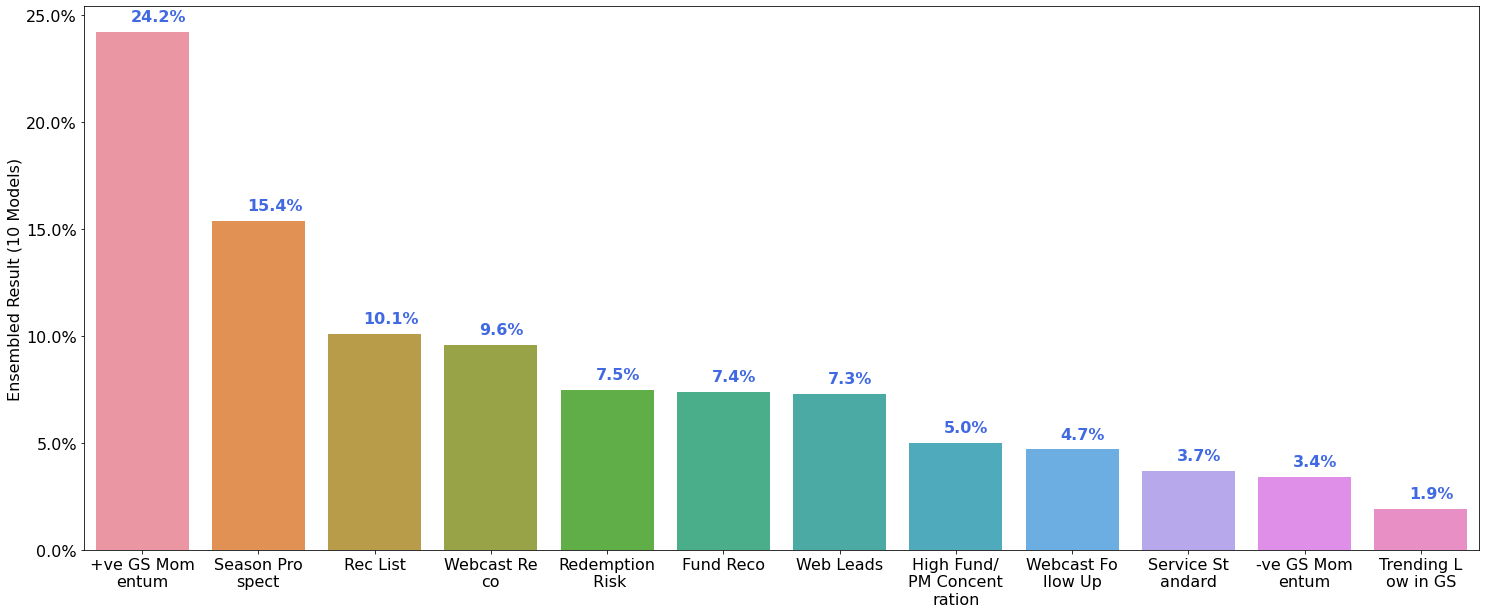

<Figure size 432x288 with 0 Axes>

In [62]:
data_for_plotting = final_ensembled_results.sort_values("Ensembled Result (10 Models)", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="Ensembled Result (10 Models)", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["Ensembled Result (10 Models)"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Ensembled_Results.png")

### First-Touch Result

['Webcast Follow Up / First Webcast Follow Up', 'Fund Reco', 'Short Term +ve GS Momentum', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Webcast Reco', 'Service Standard / BDM Service Standard', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Redemption Risk', 'Short Term -ve GS Momentum', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'High Fund/PM Concentration', 'Rec List']


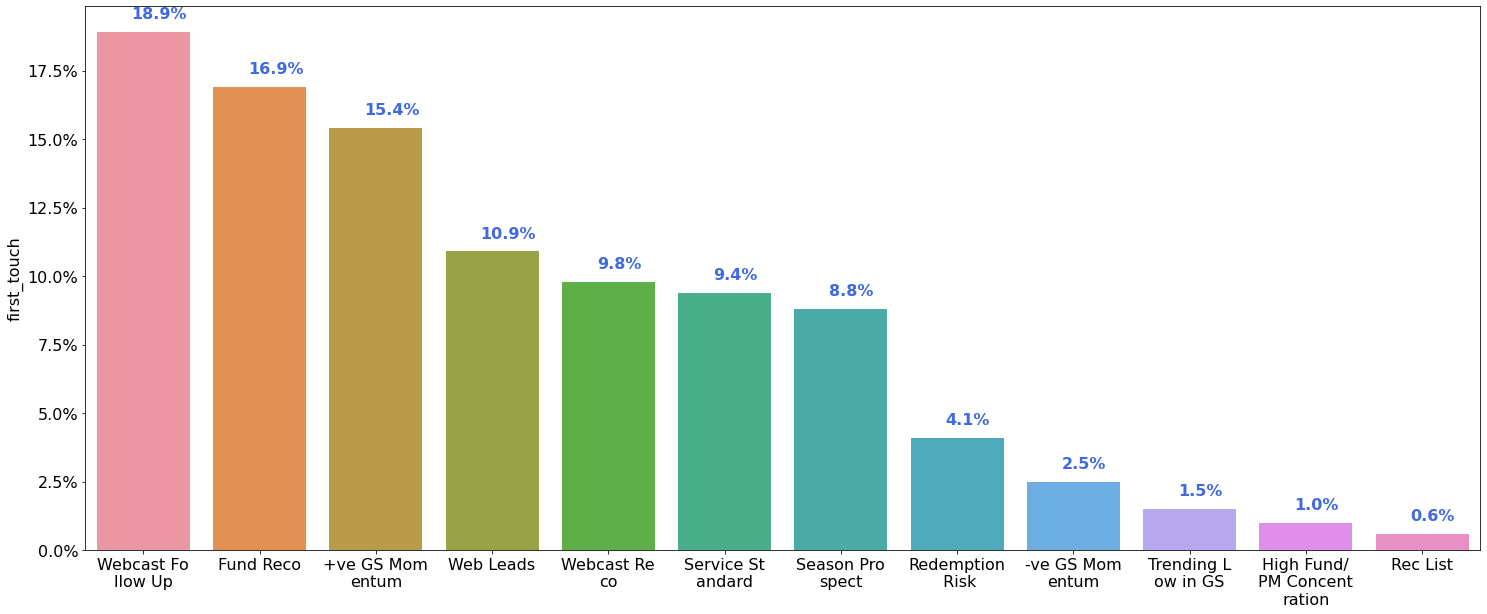

<Figure size 432x288 with 0 Axes>

In [63]:
data_for_plotting = final_ensembled_results.sort_values("first_touch", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="first_touch", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["first_touch"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/First_Touch.png")

### Last Touch Result

['Short Term +ve GS Momentum', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Webcast Reco', 'Fund Reco', 'High Fund/PM Concentration', 'Redemption Risk', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Service Standard / BDM Service Standard', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Rec List', 'Short Term -ve GS Momentum', 'Webcast Follow Up / First Webcast Follow Up']


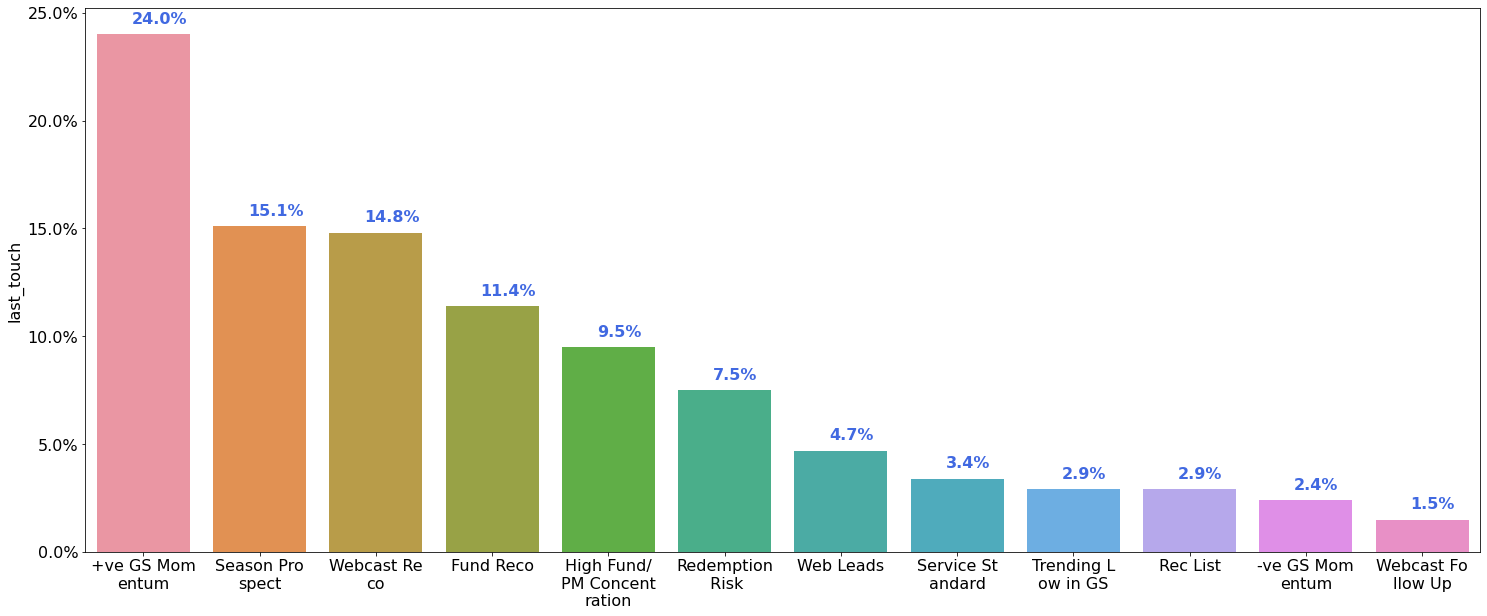

<Figure size 432x288 with 0 Axes>

In [64]:
data_for_plotting = final_ensembled_results.sort_values("last_touch", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="last_touch", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["last_touch"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Last_Touch.png")

### Linear Model Result

['RRSP/SPRING/SUMMER/FALL Prospect', 'Short Term +ve GS Momentum', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Webcast Reco', 'Rec List', 'Short Term -ve GS Momentum', 'Fund Reco', 'High Fund/PM Concentration', 'Redemption Risk', 'Webcast Follow Up / First Webcast Follow Up', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Service Standard / BDM Service Standard']


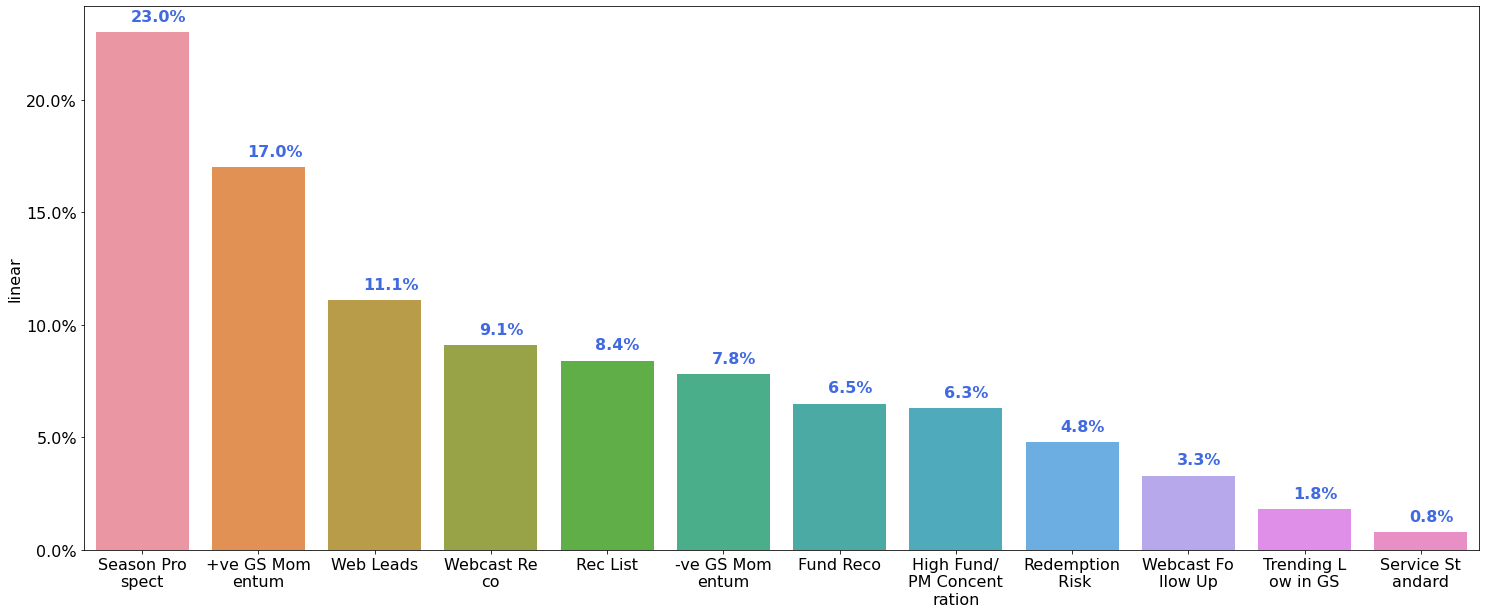

<Figure size 432x288 with 0 Axes>

In [66]:
data_for_plotting = final_ensembled_results.sort_values("linear", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="linear", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["linear"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Linear.png")

### Position Based Model Result

['RRSP/SPRING/SUMMER/FALL Prospect', 'Short Term +ve GS Momentum', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Webcast Reco', 'Short Term -ve GS Momentum', 'Fund Reco', 'High Fund/PM Concentration', 'Redemption Risk', 'Webcast Follow Up / First Webcast Follow Up', 'Rec List', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Service Standard / BDM Service Standard']


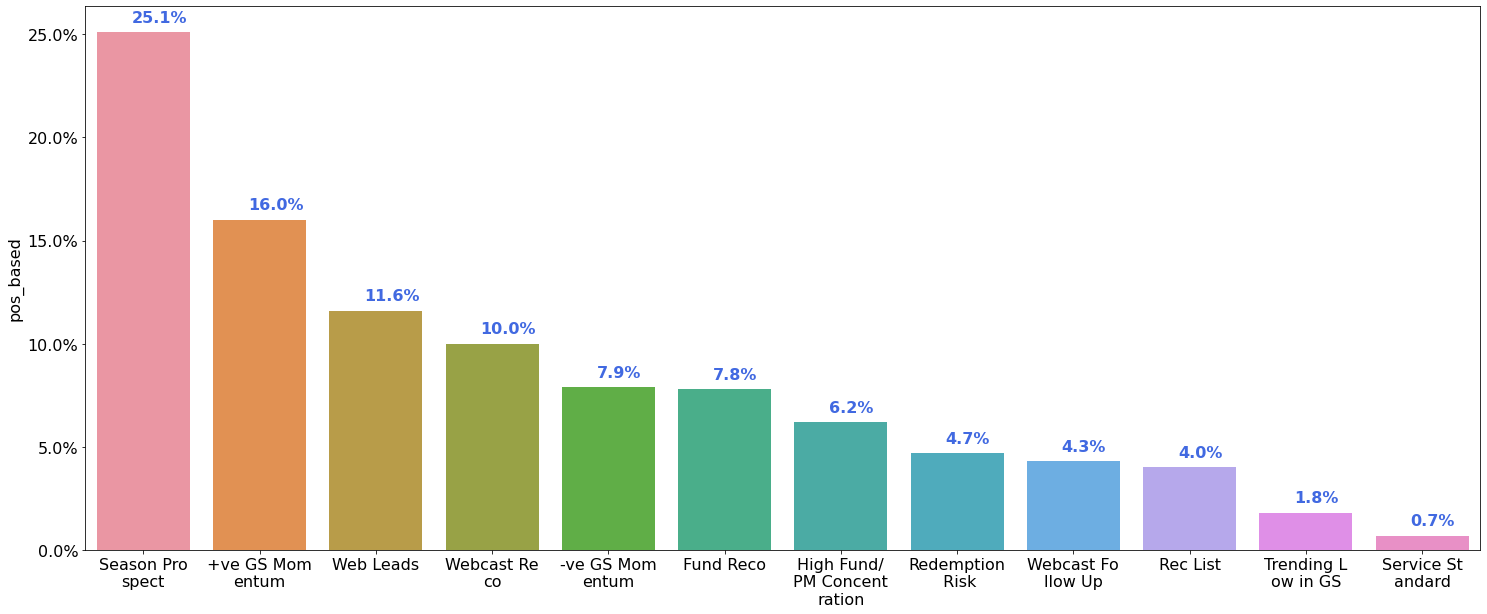

<Figure size 432x288 with 0 Axes>

In [68]:
data_for_plotting = final_ensembled_results.sort_values("pos_based", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="pos_based", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["pos_based"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Position_Based.png")

### Time Decay Model Result

['RRSP/SPRING/SUMMER/FALL Prospect', 'Short Term +ve GS Momentum', 'Webcast Reco', 'Rec List', 'Short Term -ve GS Momentum', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Fund Reco', 'High Fund/PM Concentration', 'Redemption Risk', 'Webcast Follow Up / First Webcast Follow Up', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Service Standard / BDM Service Standard']


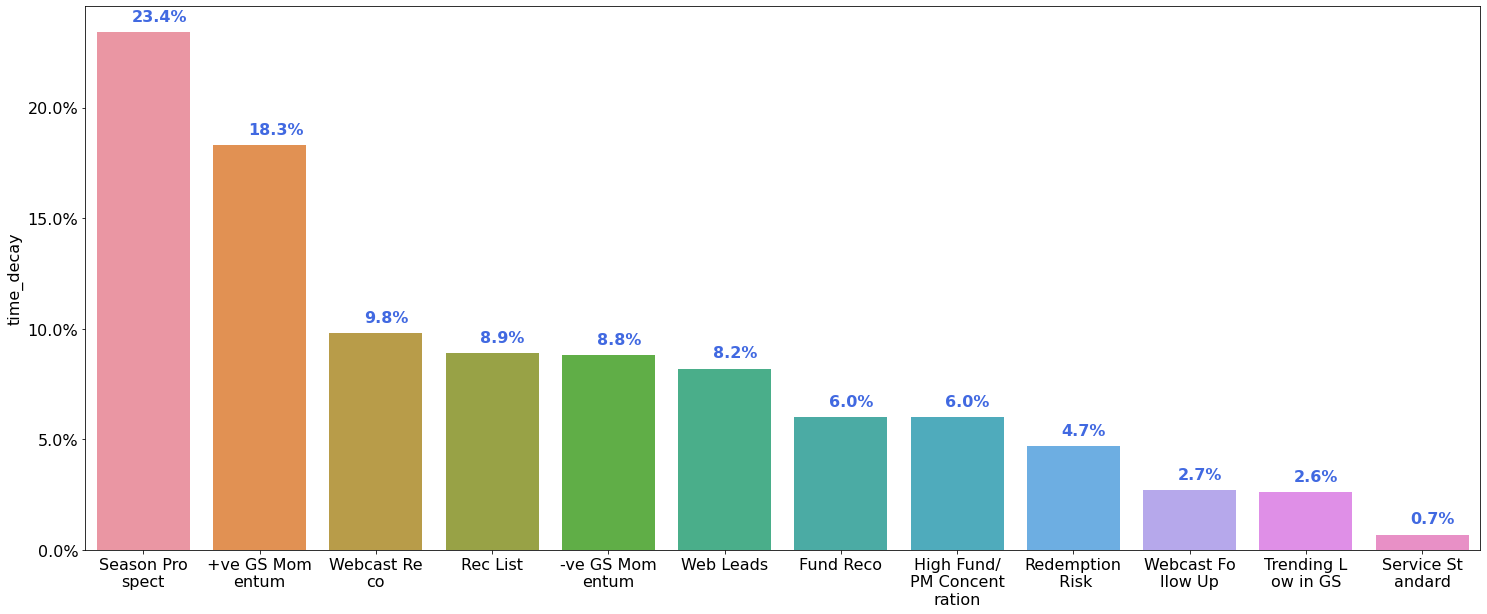

<Figure size 432x288 with 0 Axes>

In [67]:
data_for_plotting = final_ensembled_results.sort_values("time_decay", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="time_decay", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["time_decay"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Time_Decay.png")

### Shapley Value Model Result

['Short Term +ve GS Momentum', 'Rec List', 'Webcast Reco', 'Webcast Follow Up / First Webcast Follow Up', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Fund Reco', 'Service Standard / BDM Service Standard', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Redemption Risk', 'High Fund/PM Concentration', 'Short Term -ve GS Momentum', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS']


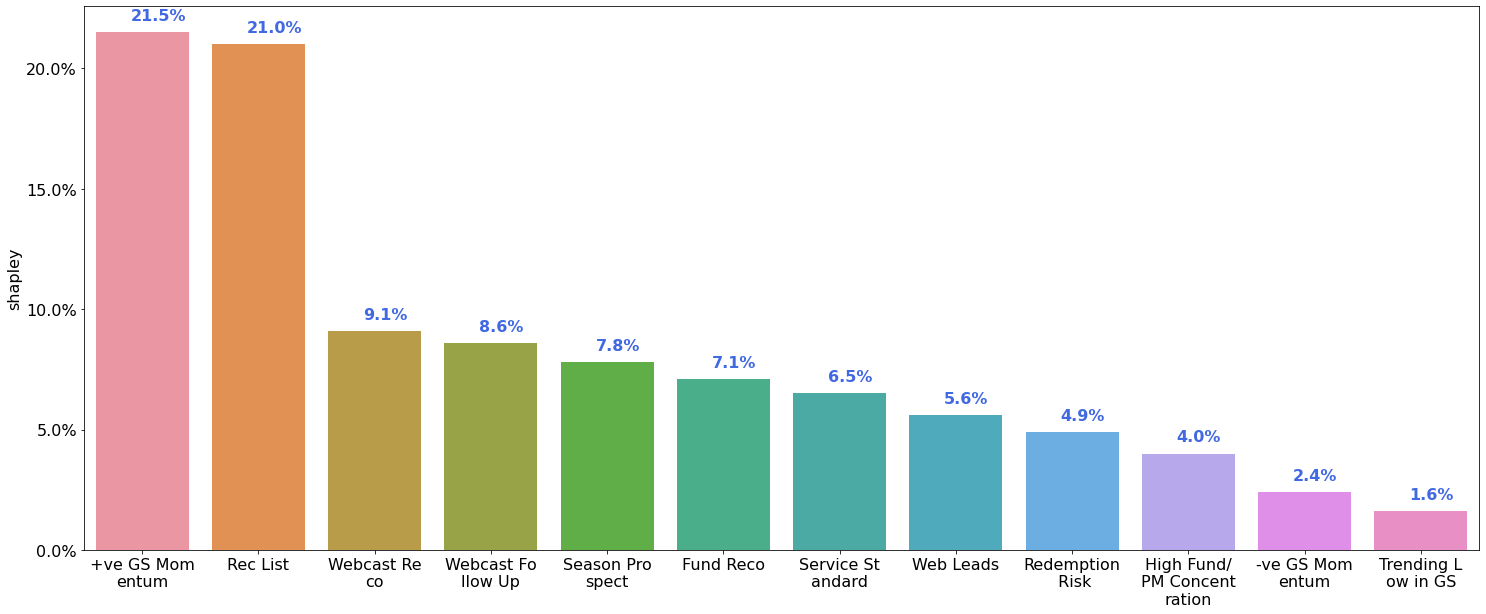

<Figure size 432x288 with 0 Axes>

In [69]:
data_for_plotting = final_ensembled_results.sort_values("shapley", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="shapley", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["shapley"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Shapley_Value.png")

### Markov Chain Model Result

['Short Term +ve GS Momentum', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Webcast Reco', 'Fund Reco', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Service Standard / BDM Service Standard', 'Redemption Risk', 'Webcast Follow Up / First Webcast Follow Up', 'Short Term -ve GS Momentum', 'High Fund/PM Concentration', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Rec List']


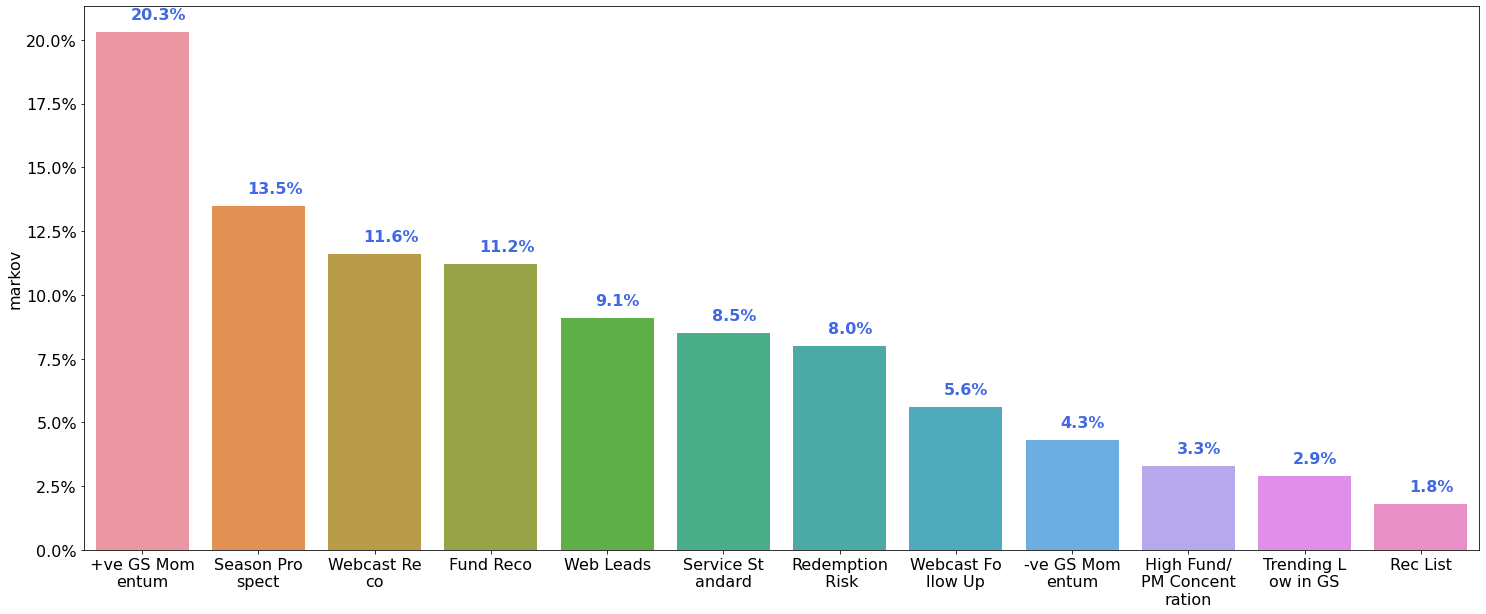

<Figure size 432x288 with 0 Axes>

In [72]:
data_for_plotting = final_ensembled_results.sort_values("markov", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="markov", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["markov"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Markov_Chain.png")

### Probablistic Model Result

['Short Term +ve GS Momentum', 'Rec List', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Webcast Reco', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Fund Reco', 'High Fund/PM Concentration', 'Webcast Follow Up / First Webcast Follow Up', 'Redemption Risk', 'Service Standard / BDM Service Standard', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Short Term -ve GS Momentum']


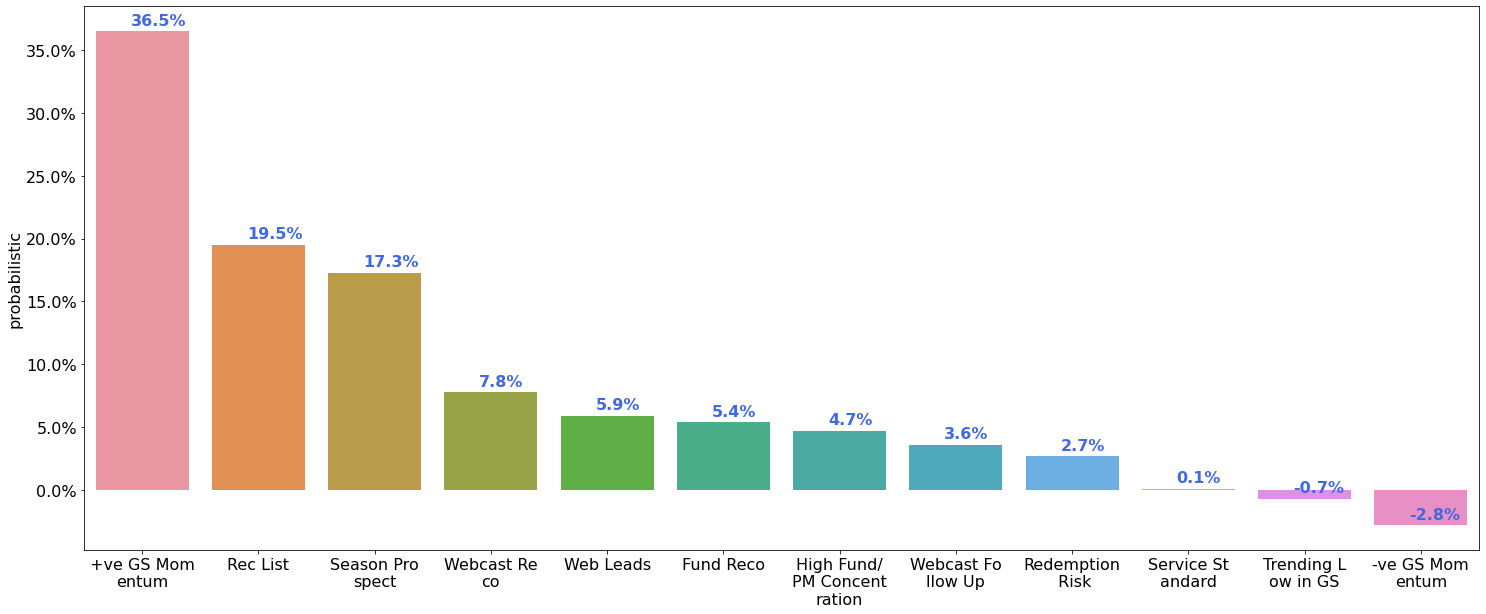

<Figure size 432x288 with 0 Axes>

In [71]:
data_for_plotting = final_ensembled_results.sort_values("probabilistic", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="probabilistic", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["probabilistic"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Probablistic_Model.png")

### Logistic Regression Model Result

['Redemption Risk', 'Short Term -ve GS Momentum', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Service Standard / BDM Service Standard', 'Fund Reco', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Webcast Reco', 'Short Term +ve GS Momentum', 'High Fund/PM Concentration', 'Webcast Follow Up / First Webcast Follow Up', 'Rec List']


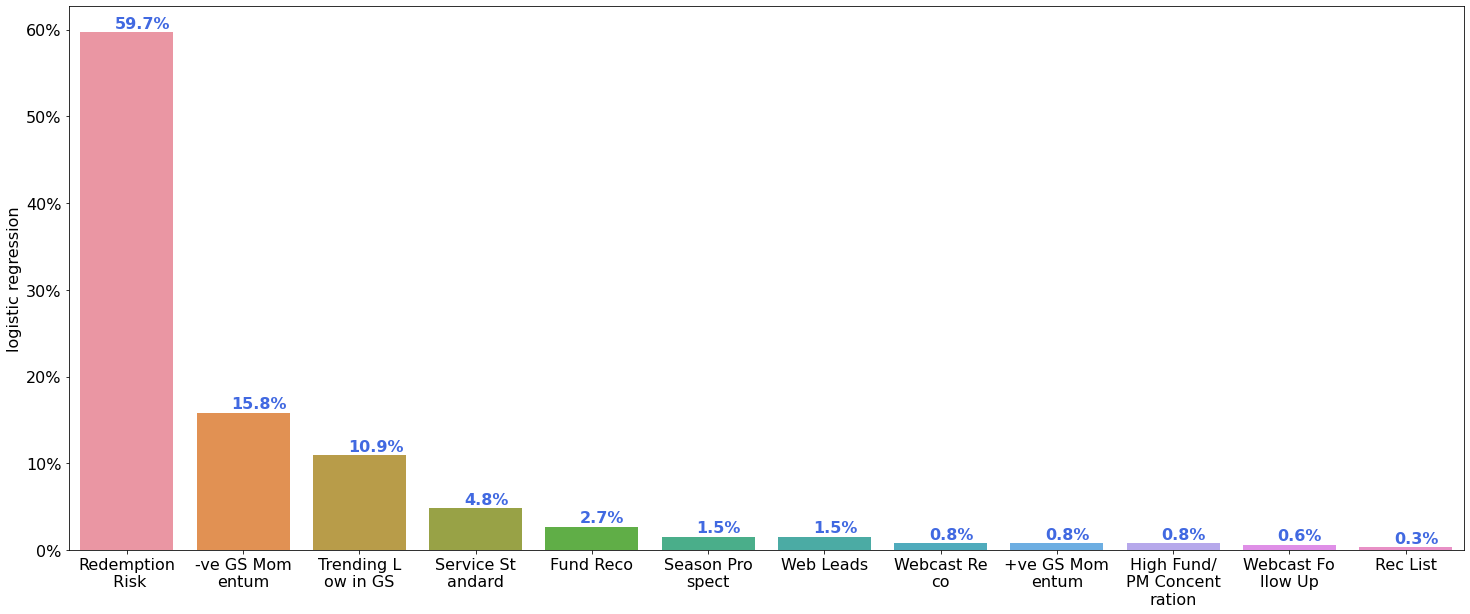

<Figure size 432x288 with 0 Axes>

In [74]:
data_for_plotting = final_ensembled_results.sort_values("logistic regression", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="logistic regression", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["logistic regression"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Logistic_Regression.png")

### Additive Hazard Model Result

['Short Term +ve GS Momentum', 'RRSP/SPRING/SUMMER/FALL Prospect', 'Webcast Reco', 'High Fund/PM Concentration', 'Web Leads/ETF Web Leads/MM Web Leads/Liq Alt Web Leads', 'Fund Reco', 'Redemption Risk', 'Rec List', 'Short Term -ve GS Momentum', 'Service Standard / BDM Service Standard', 'Trending Low in RRSP/SPRING/SUMMER/FALL GS', 'Webcast Follow Up / First Webcast Follow Up']


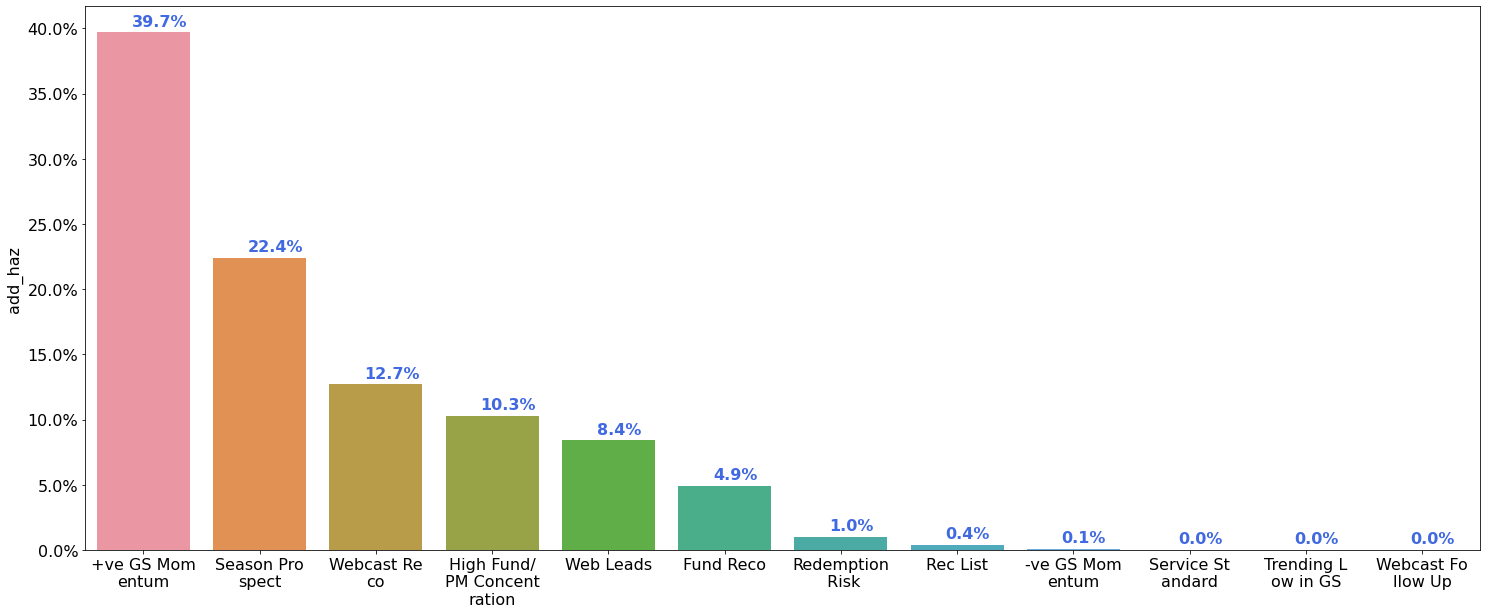

<Figure size 432x288 with 0 Axes>

In [75]:
data_for_plotting = final_ensembled_results.sort_values("add_haz", ascending = False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x = data_for_plotting.index, y="add_haz", data=data_for_plotting)
for i, v in enumerate(list(data_for_plotting["add_haz"])):
    ax.text(i-0.1, v+0.005, str(round(v*100, 1)) + '%', color='royalblue', fontweight='bold', fontsize=16)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels = [plot_name_dic[item] if item in plot_name_dic else item for item in labels ]
labels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in labels]
ax.set_xticklabels(labels)
plt.xticks(fontsize=16) #, rotation=60
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.savefig("Results/Additive_Hazard.png")